
# transfer_learning_and_clustering  

Transfer Learning + Extra Visuals

**What this does**
- Uses **frozen text features** (OpenAI embeddings if available, else TF‑IDF)  
- Trains a **Logistic Regression** classifier to predict `primary_emotion` (transfer learning)  
- Reports **accuracy** and **macro‑F1**  
- Shows **class distribution**, **confusion matrix**, and a **PCA 2D cluster map**  
- Saves a small model artifact: `emotion_logreg.pkl`




In [1]:

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Files
FEATURES_CSV = "features.csv"
EMB_NPY = "embeddings.npy"
EMB_META = "embedding_meta.csv"
TARGET = "primary_emotion"
RANDOM_STATE = 42


In [2]:

feats = pd.read_csv(FEATURES_CSV)
use_cols = ["talk_id","chunk_id", TARGET]
if "title" in feats.columns: use_cols.append("title")
if "speaker" in feats.columns: use_cols.append("speaker")
if "chunk_text" in feats.columns: use_cols.append("chunk_text")
feats = feats[use_cols].copy()
print("Rows:", len(feats))
feats.head(3)


Rows: 16128


,talk_id,chunk_id,primary_emotion,title,speaker
0,0,0,neutral,Averting the climate crisis,Al Gore
1,0,1,neutral,Averting the climate crisis,Al Gore
2,0,2,neutral,Averting the climate crisis,Al Gore


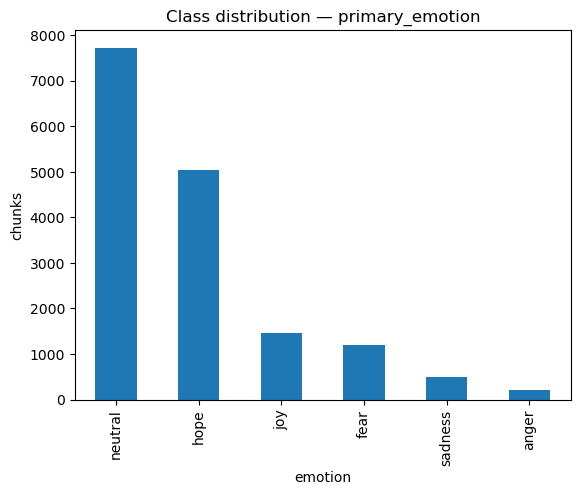

In [3]:

plt.figure()
feats[TARGET].fillna("neutral").value_counts().plot(kind="bar")
plt.title("Class distribution — primary_emotion")
plt.xlabel("emotion"); plt.ylabel("chunks"); plt.show()


In [4]:

X, X_source = None, ""

if Path(EMB_NPY).exists() and Path(EMB_META).exists():
    emb = np.load(EMB_NPY)
    meta = pd.read_csv(EMB_META)
    kf = feats.set_index(["talk_id","chunk_id"]).sort_index()
    km = meta.set_index(["talk_id","chunk_id"]).sort_index()
    common = kf.index.intersection(km.index)
    if len(common) == 0:
        raise ValueError("No overlapping rows between features.csv and embedding_meta.csv on (talk_id, chunk_id).")
    kf = kf.loc[common]
    km = km.loc[common]
    order = km.reset_index().index.values
    X = emb[order]
    feats = kf.reset_index()
    X_source = "embeddings"
    print("Using embeddings:", X.shape)
else:
    assert "chunk_text" in feats.columns, "No embeddings found and chunk_text missing for TF‑IDF fallback."
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
    X = tfidf.fit_transform(feats["chunk_text"].fillna(" ")).astype("float32")
    X_source = "tfidf"
    print("Using TF‑IDF:", X.shape)


Using embeddings: (1500, 1536)


In [6]:

y = feats[TARGET].fillna("neutral")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

if X_source == "embeddings":
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
else:
    scaler = None

clf = LogisticRegression(max_iter=300, n_jobs=1 if X_source=="tfidf" else None)
clf.fit(X_train, y_train)

pred = clf.predict(X_val)
acc = accuracy_score(y_val, pred)
f1  = f1_score(y_val, pred, average="macro")
print(f"Accuracy: {acc:.3f} | Macro‑F1: {f1:.3f}")
print("\nClassification report:\n", classification_report(y_val, pred))


Accuracy: 0.327 | Macro‑F1: 0.154

Classification report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00         3
        fear       0.13      0.10      0.11        20
        hope       0.25      0.28      0.27        93
         joy       0.11      0.07      0.09        28
     neutral       0.44      0.47      0.46       144
     sadness       0.00      0.00      0.00        12

    accuracy                           0.33       300
   macro avg       0.16      0.15      0.15       300
weighted avg       0.31      0.33      0.32       300



/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


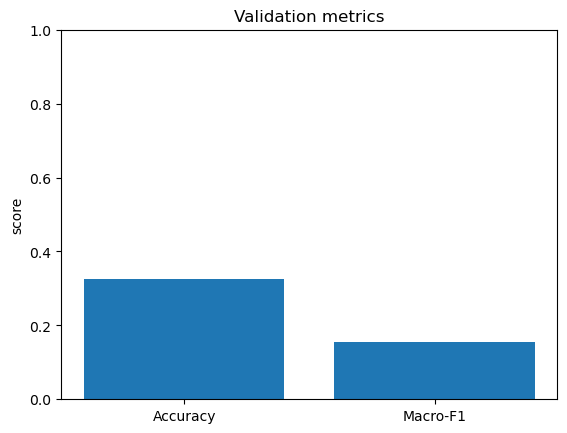

In [7]:

plt.figure()
plt.bar(["Accuracy","Macro‑F1"], [acc, f1])
plt.title("Validation metrics")
plt.ylabel("score"); plt.ylim(0, 1)
plt.show()


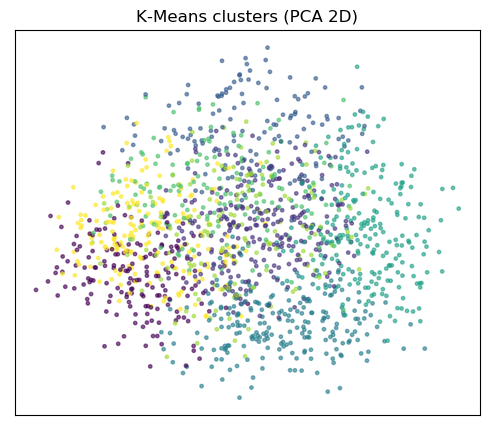


Cluster 0 — sample rows:


,talk_id,chunk_id,title,speaker,primary_emotion
0,7,1,Let's teach religion -- all religion -- in sch...,Dan Dennett,neutral
1,12,4,One Laptop per Child,Nicholas Negroponte,hope
2,20,2,Nerdcore comedy,Ze Frank,neutral



Cluster 1 — sample rows:


,talk_id,chunk_id,title,speaker,primary_emotion
0,0,3,Averting the climate crisis,Al Gore,hope
1,4,1,Do schools kill creativity?,Sir Ken Robinson,neutral
2,7,0,Let's teach religion -- all religion -- in sch...,Dan Dennett,joy



Cluster 2 — sample rows:


,talk_id,chunk_id,title,speaker,primary_emotion
0,16,2,Simple designs to save a life,Amy Smith,joy
1,27,5,The freakonomics of crack dealing,Steven Levitt,fear
2,43,6,How technology evolves,Kevin Kelly,neutral



Cluster 3 — sample rows:


,talk_id,chunk_id,title,speaker,primary_emotion
0,3,0,Greening the ghetto,Majora Carter,joy
1,12,0,One Laptop per Child,Nicholas Negroponte,neutral
2,26,4,"Choice, happiness and spaghetti sauce",Malcolm Gladwell,joy



Cluster 4 — sample rows:


,talk_id,chunk_id,title,speaker,primary_emotion
0,31,0,A roadmap to end aging,Aubrey de Grey,hope
1,60,4,In praise of slowness,Carl Honoré,hope
2,64,0,To invent is to give,Dean Kamen,hope


In [9]:

Z = X if X_source == "embeddings" else X.toarray()
Zc = Z - Z.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
Z2d = U[:, :2] * S[:2]

k = 8
km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
clusters = km.fit_predict(Z)

plt.figure(figsize=(6,5))
plt.scatter(Z2d[:,0], Z2d[:,1], s=6, alpha=0.6, c=clusters)
plt.title("K‑Means clusters (PCA 2D)")
plt.xticks([]); plt.yticks([])
plt.show()

for c in range(min(5, k)):
    idx = np.where(clusters==c)[0][:3]
    cols = [c for c in ["talk_id","chunk_id","title","speaker", TARGET] if c in feats.columns]
    print(f"\nCluster {c} — sample rows:")
    display(feats.iloc[idx][cols].reset_index(drop=True))


In [10]:

import pickle
with open("emotion_logreg.pkl", "wb") as f:
    pickle.dump({"model": clf, "scaler": scaler, "labels": sorted(y.unique()), "feature_source": X_source}, f)
print("Saved emotion_logreg.pkl")


Saved emotion_logreg.pkl
